<img src='http://hilpisch.com/tpq_logo.png' width="300px" align="right">

# FPQ Bootcamp &mdash; Day 4

**Deep Learning with TensorFlow**

## Financial Data

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                 index_col=0, parse_dates=True)

In [3]:
sym = 'SPY'

In [4]:
data = pd.DataFrame(raw[sym])

In [5]:
data['Returns'] = np.log(data / data.shift(1))

## Prepare Features

In [6]:
lags = 10

In [7]:
cols = []
for lag in range(1, lags + 1):
    col = 'lags_%d' % lag
    data[col] = np.where(data['Returns'].shift(lag) > 0, 1, 0)
    cols.append(col)

In [8]:
cols

['lags_1',
 'lags_2',
 'lags_3',
 'lags_4',
 'lags_5',
 'lags_6',
 'lags_7',
 'lags_8',
 'lags_9',
 'lags_10']

In [9]:
data = data.iloc[lags:]

In [10]:
data.head(7)

,SPY,Returns,lags_1,lags_2,lags_3,lags_4,lags_5,lags_6,lags_7,lags_8,lags_9,lags_10
Date,,,,,,,,,,,,
2010-01-19,115.06,0.012418,0,1,1,0,1,1,1,1,1,0
2010-01-20,113.89,-0.010221,1,0,1,1,0,1,1,1,1,1
2010-01-21,111.70,-0.019416,0,1,0,1,1,0,1,1,1,1
2010-01-22,109.21,-0.022544,0,0,1,0,1,1,0,1,1,1
2010-01-25,109.77,0.005115,0,0,0,1,0,1,1,0,1,1
2010-01-26,109.31,-0.004199,1,0,0,0,1,0,1,1,0,1
2010-01-27,109.83,0.004746,0,1,0,0,0,1,0,1,1,0


## TensorFlow

In [11]:
# !conda install -y tensorflow

In [12]:
import tensorflow as tf

In [13]:
tf.logging.set_verbosity(tf.logging.ERROR)

### Defining Feature Columns

In [14]:
fc = tf.contrib.layers.real_valued_column('lags', dimension=lags)

### Defining the Data Function

In [15]:
def get_data():
    fc = {'lags': tf.constant(data[cols].values)}
    la = tf.constant(np.where(data['Returns'] > 0, 1, 0))
    return fc, la

### Defining the Model

In [16]:
model = tf.contrib.learn.DNNClassifier(hidden_units=[50, 50],
                                       feature_columns=[fc])

In [17]:
model

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x119f7cf28>, 'hidden_units': [50, 50], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=10, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x117c0e8c8>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

### Fitting the Model

In [18]:
%time model.fit(input_fn=get_data, steps=250)

CPU times: user 3.05 s, sys: 209 ms, total: 3.25 s
Wall time: 1.87 s


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x119f7cf28>, 'hidden_units': [50, 50], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=10, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x117c0e8c8>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

### Predicting Market Direction

In [19]:
%time pred = model.predict(input_fn=get_data)

CPU times: user 159 ms, sys: 10 ms, total: 169 ms
Wall time: 166 ms


In [20]:
data['Prediction'] = list(pred)

In [21]:
data['Prediction'].value_counts()

1    1800
0     162
Name: Prediction, dtype: int64

In [22]:
data['Position'] = np.where(data['Prediction'] > 0, 1, -1)

In [23]:
data['Position'].value_counts()

 1    1800
-1     162
Name: Position, dtype: int64

### Evaluation

In [24]:
model.evaluate(input_fn=get_data, steps=1)

{'accuracy': 0.5575943,
 'accuracy/baseline_label_mean': 0.54638124,
 'accuracy/threshold_0.500000_mean': 0.5575943,
 'auc': 0.57244992,
 'global_step': 250,
 'labels/actual_label_mean': 0.54638124,
 'labels/prediction_mean': 0.54625636,
 'loss': 0.68263215,
 'precision/positive_threshold_0.500000_mean': 0.55666667,
 'recall/positive_threshold_0.500000_mean': 0.9347015}

### Backtesting

In [25]:
data['Strategy'] = data['Position'] * data['Returns']

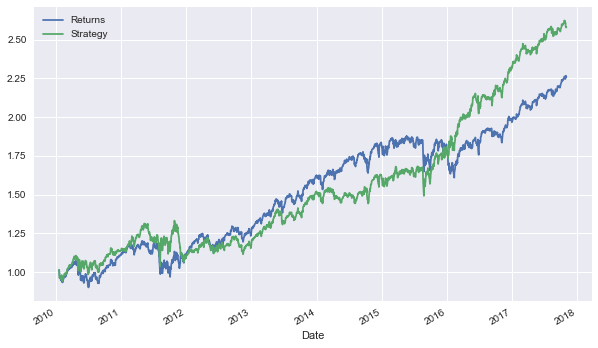

In [26]:
data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## In-Sample vs. Out-of-Sample

In [27]:
cutoff = '2015-1-1'

## Training the Model

In [28]:
def get_training_data():
    global training
    training = data.loc[:cutoff].copy()
    fc = {'lags': tf.constant(training[cols].values)}
    la = tf.constant(np.where(training['Returns'] > 0, 1, 0))
    return fc, la

In [29]:
model = tf.contrib.learn.DNNClassifier(hidden_units=[100, 100],
                                       feature_columns=[fc])

In [30]:
%time model.fit(input_fn=get_training_data, steps=250)

CPU times: user 4.23 s, sys: 209 ms, total: 4.44 s
Wall time: 2.18 s


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x11153f4a8>, 'hidden_units': [100, 100], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=10, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x117c0e8c8>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [31]:
%time pred = model.predict(input_fn=get_training_data)

CPU times: user 163 ms, sys: 8.36 ms, total: 172 ms
Wall time: 162 ms


In [32]:
# training.info()

In [33]:
training['Position'] = np.where(np.array(list(pred)) > 0, 1, -1)

In [34]:
training['Position'].value_counts()

 1    1142
-1     106
Name: Position, dtype: int64

In [35]:
model.evaluate(input_fn=get_training_data, steps=1)

{'accuracy': 0.58653843,
 'accuracy/baseline_label_mean': 0.55769229,
 'accuracy/threshold_0.500000_mean': 0.58653843,
 'auc': 0.61354995,
 'global_step': 250,
 'labels/actual_label_mean': 0.55769229,
 'labels/prediction_mean': 0.55788469,
 'loss': 0.67347383,
 'precision/positive_threshold_0.500000_mean': 0.57880908,
 'recall/positive_threshold_0.500000_mean': 0.94971263}

In [36]:
training['Strategy'] = training['Position'] * training['Returns']

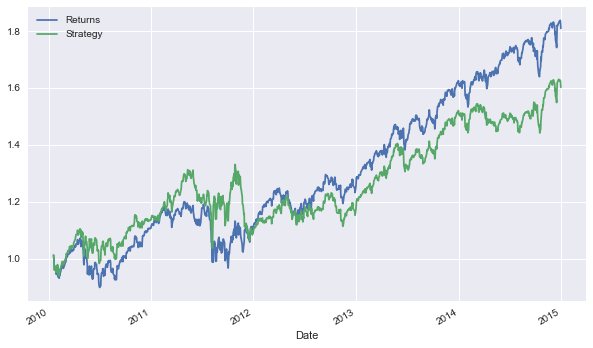

In [37]:
training[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Testing the Model

In [38]:
def get_test_data():
    global test
    test = data.loc[cutoff:].copy()
    fc = {'lags': tf.constant(test[cols].values)}
    la = tf.constant(np.where(test['Returns'] > 0, 1, 0))
    return fc, la

In [39]:
%time pred = model.predict(input_fn=get_test_data)

CPU times: user 160 ms, sys: 8.77 ms, total: 168 ms
Wall time: 158 ms


In [40]:
test['Position'] = np.where(np.array(list(pred)) > 0, 1, -1)

In [41]:
test['Position'].value_counts()

 1    660
-1     54
Name: Position, dtype: int64

In [42]:
model.evaluate(input_fn=get_test_data, steps=1)

{'accuracy': 0.52661067,
 'accuracy/baseline_label_mean': 0.52661067,
 'accuracy/threshold_0.500000_mean': 0.52661067,
 'auc': 0.50460315,
 'global_step': 250,
 'labels/actual_label_mean': 0.52661067,
 'labels/prediction_mean': 0.55635786,
 'loss': 0.69572294,
 'precision/positive_threshold_0.500000_mean': 0.52878785,
 'recall/positive_threshold_0.500000_mean': 0.92819148}

In [43]:
test['Strategy'] = test['Position'] * test['Returns']

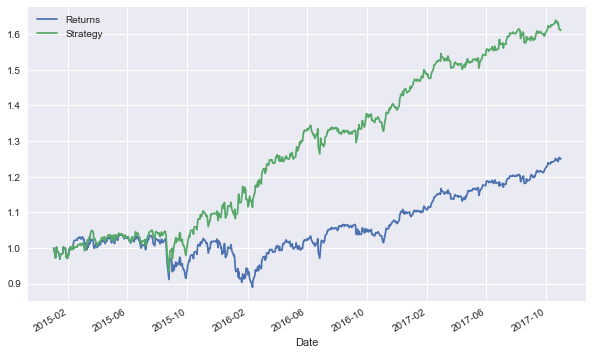

In [44]:
test[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

<img src='http://hilpisch.com/tpq_logo.png' width="300px" align="right">